In [1]:
import sys
sys.path.append('../')

In [2]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output

import torch
import torch.nn as nn
import torchvision.transforms as transforms

from model import TSFashionNet
from dataset import TSDataset
from utils import add_weight_heatmap

In [3]:
device = torch.device(
        "cuda" if torch.cuda.is_available() else "cpu"
    )

In [4]:
model = TSFashionNet().to(device)

In [5]:
ckpt_dict = torch.load('/media/jaeho/HDD/ckpt/TSFashionNet/TSFashionNet_220925-0219/checkpoint-006-13.185.pth')

In [6]:
ckpt_dict.keys()

dict_keys(['epoch', 'model_state_dict'])

In [7]:
model.load_state_dict(ckpt_dict['model_state_dict'])

<All keys matched successfully>

In [8]:
model.eval()

TSFashionNet(
  (texture_backbone): VggBackbone(
    (conv1): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (conv2): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (conv3): Sequential(
      (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): Conv2d(256, 256, kernel_size=(3, 

In [9]:
test_dataset = TSDataset('/media/jaeho/SSD/datasets/deepfashion/split/test.pickle')

In [10]:
target_idx = np.random.randint(len(test_dataset))
target_idx

5940

In [11]:
try_num = 10

In [12]:
trans = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor()
    ])

In [13]:
def landmark_check(img, lm_out, landmark):
    for idx, lm in enumerate(lm_out.squeeze()):
        lm = transforms.ToPILImage()(lm)
        lm = transforms.Resize((width, height))(lm)
        lm = transforms.ToTensor()(lm)
        
        if idx == 0:
            upsized_lm = lm
        else :
            upsized_lm = torch.cat([upsized_lm, lm], axis=0)
    
    lm_gt = add_weight_heatmap(img, landmark, plot=False)
    lm_pred = add_weight_heatmap(img, upsized_lm.numpy(), plot=False)
    
    plt.figure(figsize=(10, 15))
    plt.subplot(1,3,1)
    plt.imshow(img)
    plt.subplot(1,3,2)
    plt.imshow(lm_gt)
    plt.subplot(1,3,3)
    plt.imshow(lm_pred)
    plt.show()

In [96]:
def category_check(cat_gt, cat_pred):
    cat_gt = cat_gt.item()
    cat_pred = torch.argmax(cat_pred).detach().cpu().numpy().item()
    if cat_gt == cat_pred:
        print("correct")
    else :
        print("incorrect")
    print(f"gt:\t{cat_gt}\npred:\t{cat_pred}")
    
    return cat_gt, cat_pred

In [110]:
def attribute_check(attr_gt, attr_pred, thr=None):
    
    attr_gt = [x[0] for x in attr_gt.nonzero().numpy()]
    
    if thr:
        attr_pred = torch.where(attr_pred>=thr, 1, 0).detach().cpu()
        attr_pred = [x[0] for x in attr_pred.nonzero().numpy()]
    else :
        attr_pred = {idx:value for idx, value in enumerate(attr_out.detach().cpu().numpy())}
        attr_pred = dict(sorted(attr_pred.items(), reverse=True, key=lambda x: x[1]))
        attr_pred = list(attr_pred.keys())[:len(attr_gt)]
        
    # check correct
    attr_cor = [True if x in attr_pred else False for x in attr_gt]
    
    return attr_gt, attr_pred, attr_cor

In [108]:
def visibility_check(vis_gt, vis_pred, thr=0.8):
    vis_gt = vis_gt.numpy().astype(np.int32)
    vis_pred = torch.where(vis_pred>=thr, 1, 0).detach().cpu().numpy()
    
    return vis_gt, vis_pred, vis_gt==vis_pred

9 / 10
14204


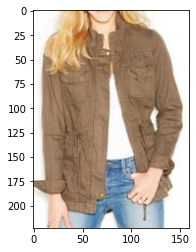

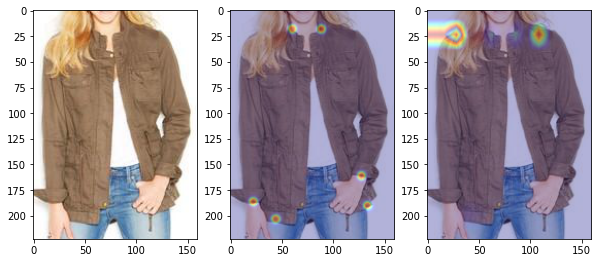

incorrect
gt:	10
pred:	28

[]
[]
[]

[1 1 1 1 0 0 1 1]
[0 1 0 1 0 0 1 1]
[False  True False  True  True  True  True  True]


 ㅇ


In [113]:
for t_n in range(try_num):
    print(f"{t_n+1} / {try_num}")
    target_idx = np.random.randint(len(test_dataset))
    print(target_idx)
    img, category, attribute, visibility, landmark = test_dataset[target_idx]
    height, width = img.size
    plt.imshow(img)
    plt.show()
    
    img_tensor = trans(img).to(device)
    img_tensor = torch.unsqueeze(img_tensor, axis=0)
    vis_out, lm_out, category_out, attr_out = model(img_tensor, shape=False)
    
    
    ############## check landmark
    # down_size
    # resized_img = img.resize((14, 14))
    # pred_lm = add_weight_heatmap(resized_img, lm_out.detach().cpu().squeeze().numpy(), plot=False)
    # break
    
    landmark_check(img, lm_out, landmark)
    ##################################
    
    #### category
    
    category_check(category, category_out)
    # cat_gt = category.item()
    # cat_pred = torch.argmax(category_out).detach().cpu().numpy().item()
    # if cat_gt==cat_pred:
    #     print("correct")
    # else:
    #     print("incorrect")
    # print(f'gt:\t{cat_gt}\npred:\t{cat_pred}')
    
    #### attribute
    attr_gt, attr_pred, attr_cor = attribute_check(attribute, attr_out, thr=0.3)
    print()
    print(attr_gt)
    print(attr_pred)
    print(attr_cor)
    
    #### visibility
    vis_gt, vis_pred, vis_cor = visibility_check(visibility, vis_out)
    print()
    print(vis_gt)
    print(vis_pred)
    print(vis_cor)
    
    
    
    ############### break
    input_str = input()
    if input_str == "":
        clear_output()
    else :
        break

## to do
1. attribute 전처리 값 확인
    - gt자체도 아무런 값이 안들어갈 경우가 존재
    - unknown? 그러한 라벨도 존재했었는데 일괄적으로 다 0으로 처리하고 명확한 정보에 대해서만 1이라고 전처리를 했었는데 이 부분을 변경해서도 준비해봐야 할 것 같음
2. landmark 학습 디버깅
    - loss는 분명 뭔가 줄어드는 걸로 보였는데, 실제로 결과를 확인해보면 처참
    - visibility가 분명 loss 계산시에 같이 들어가기는 하는데..
    - 그리고 gt값을 무지성으로 사이즈를 줄여서 pred와 비교를 하는데 여기서 pred를 키워본다면?
    - 문제점 예상
        1. loss 설계 문제?
        2. pred값 upsize? (gt값 downsize?)